Rolling Forecast (lstm):   0%|          | 0/13 [00:00<?, ?it/s]2024-07-20 11:02:21.501652: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-07-20 11:02:21.501734: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (plealm): /proc/driver/nvidia/version does not exist
2024-07-20 11:02:21.503238: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Rolling Forecast (lstm):  31%|███       | 4/13 [00:16<00:35,  3.90s/it]

Rolling Forecast (lstm):  38%|███▊      | 5/13 [00:20<00:32,  4.01s/it]

Rolling Forecast (lstm): 100%|██████████| 13/13 [00:58<00:00,  4.51s/it]


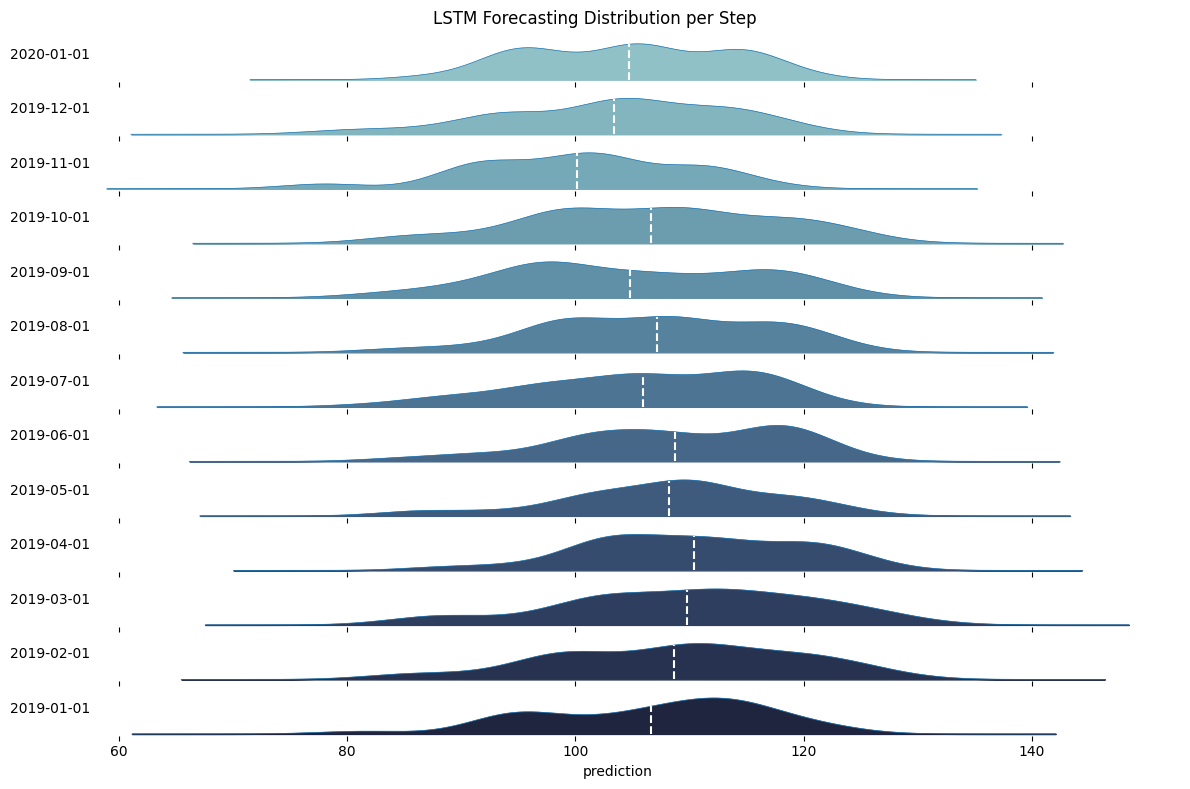

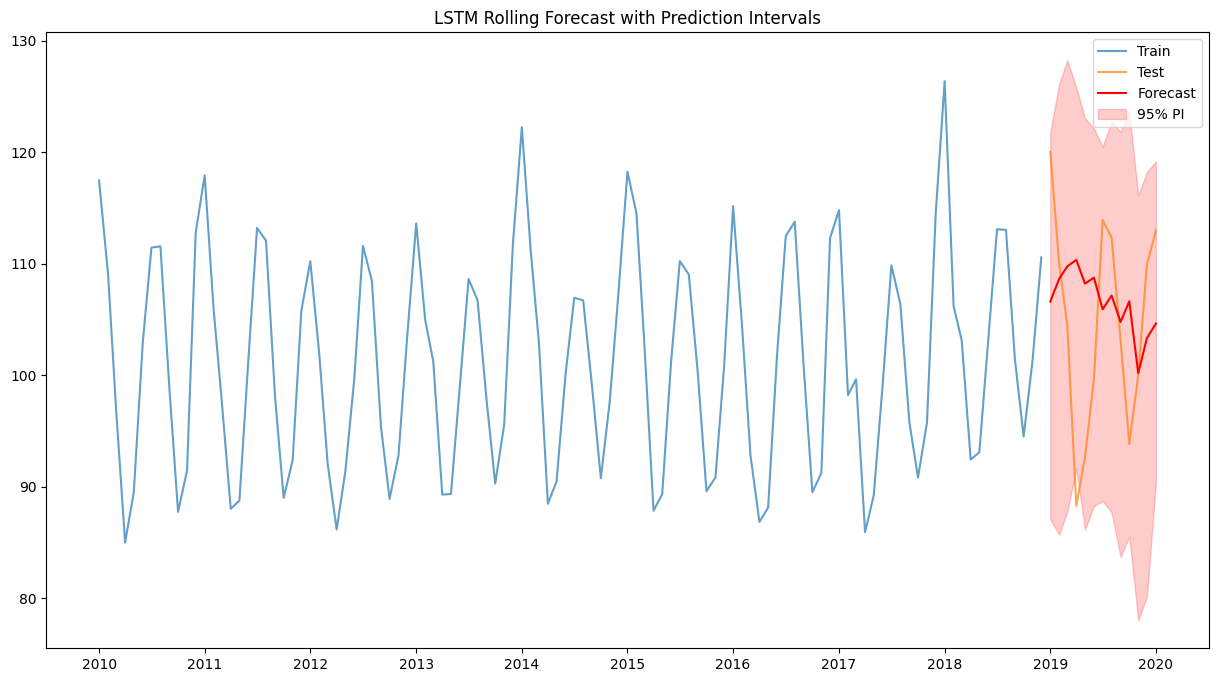

CRPS Score for lstm model: 5.090159076960569


Rolling Forecast (gru): 100%|██████████| 13/13 [01:20<00:00,  6.16s/it]


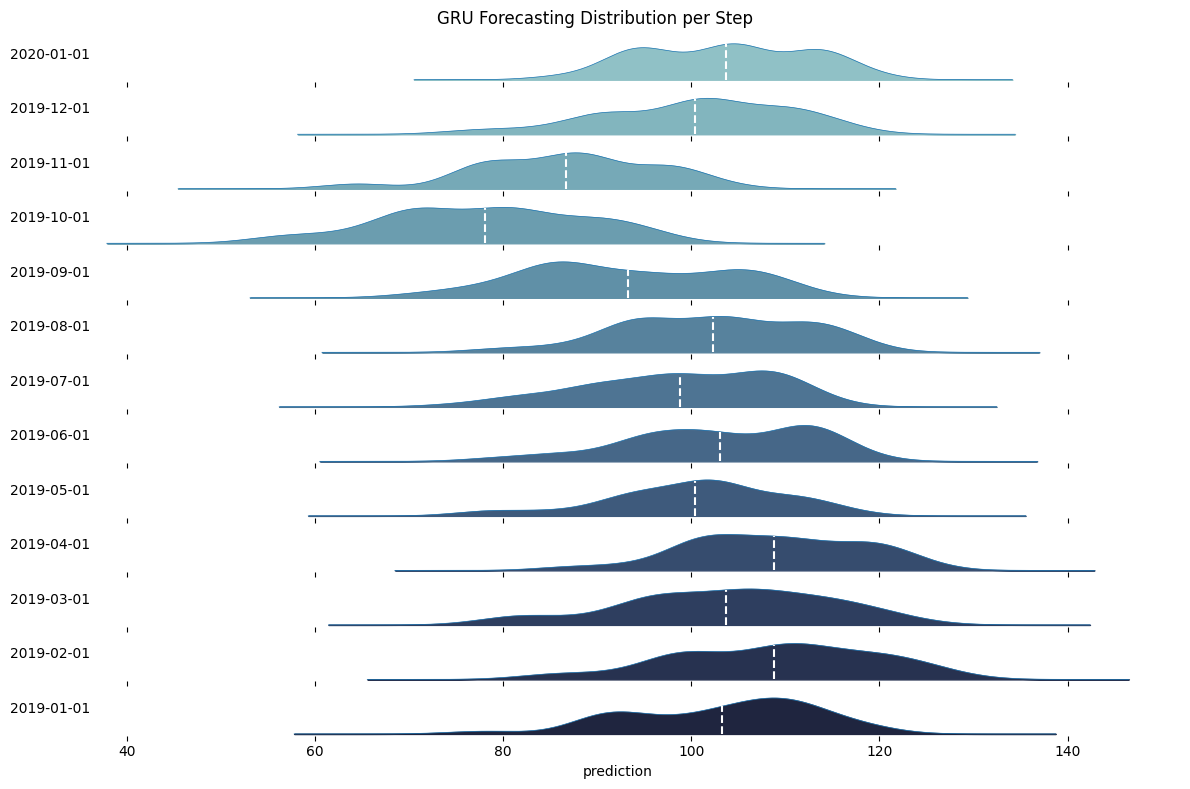

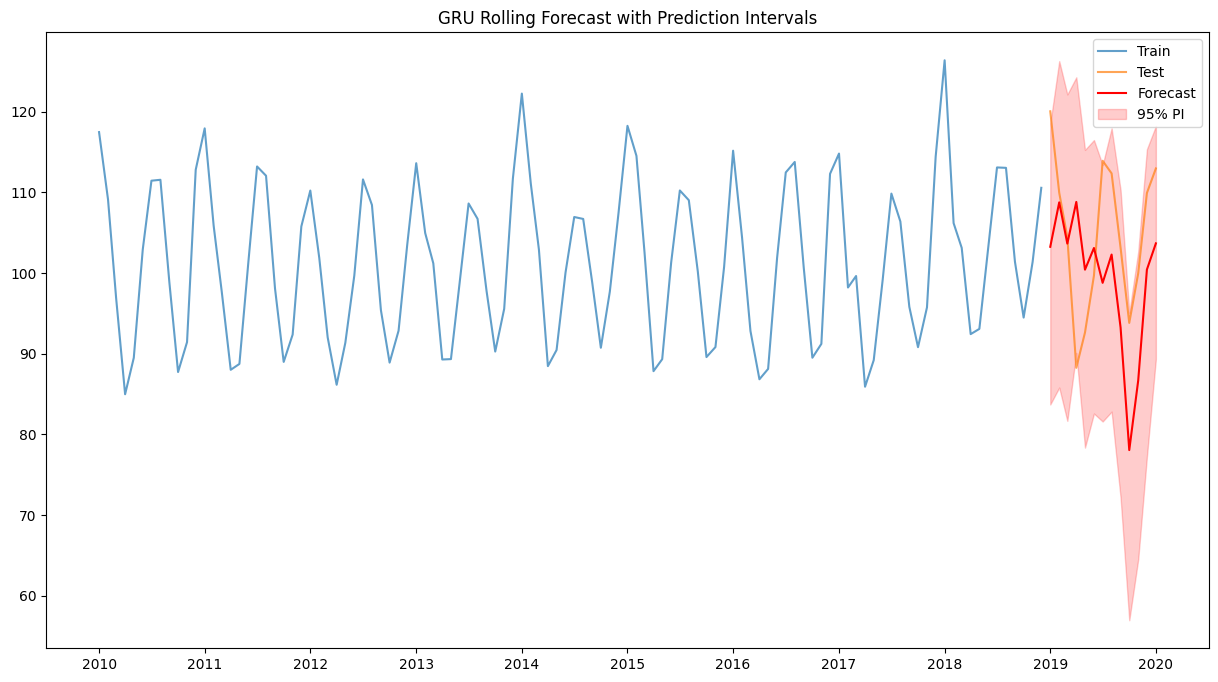

CRPS Score for gru model: 5.725868557808578


Rolling Forecast (simple_rnn): 100%|██████████| 13/13 [00:53<00:00,  4.12s/it]


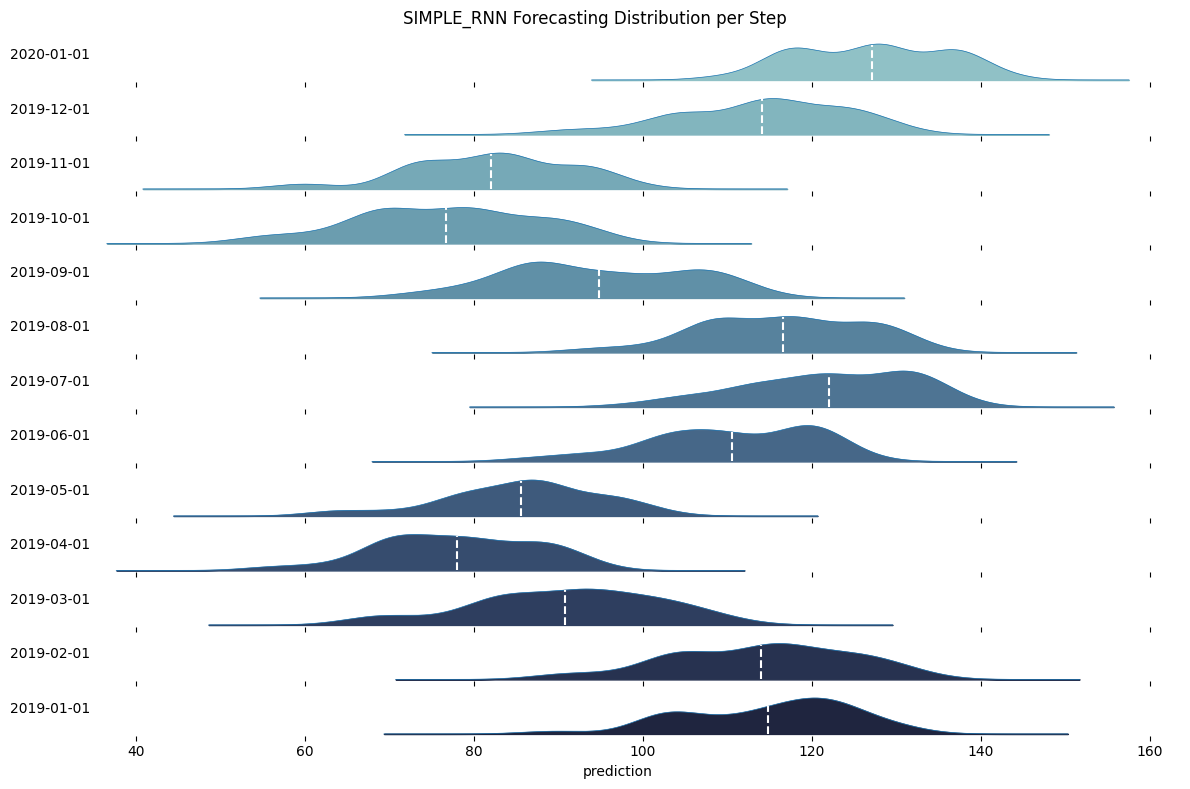

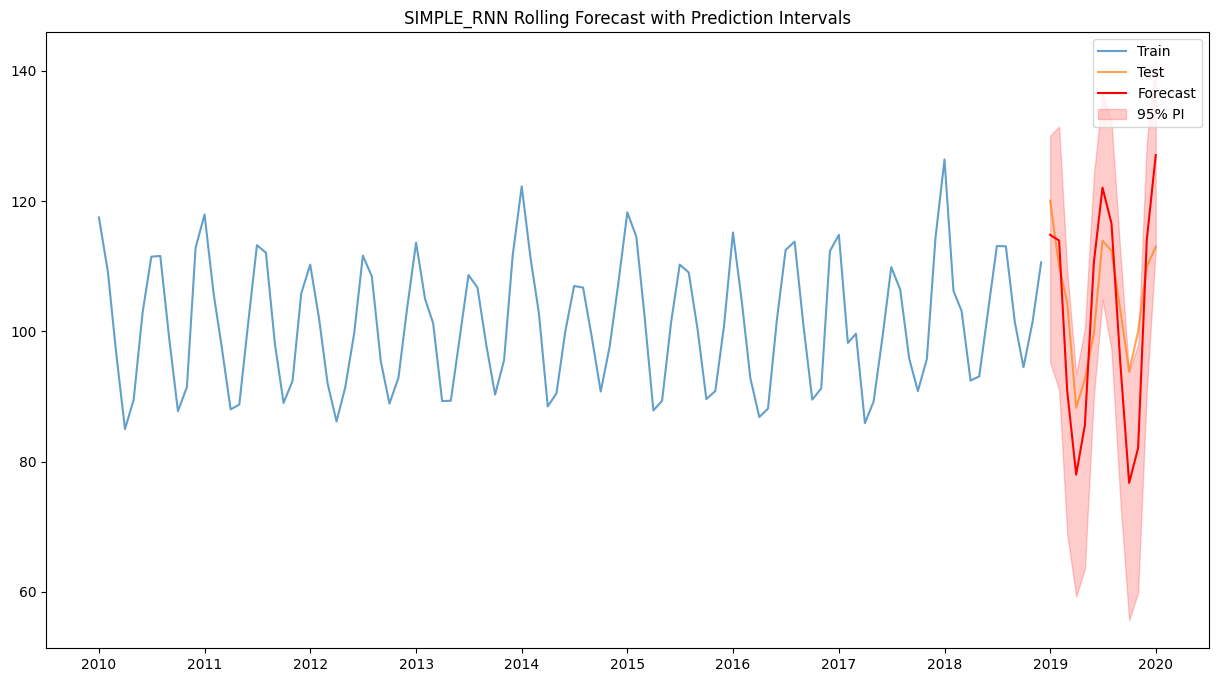

CRPS Score for simple_rnn model: 6.613287350307346
           Family       Model      CRPS
0  Neural Network        LSTM  5.090159
1  Neural Network         GRU  5.725869
2  Neural Network  SIMPLE_RNN  6.613287


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from typing import Optional, Any
from tqdm import tqdm
import scoringrules as sr
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import random

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

warnings.filterwarnings('ignore')

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', input_shape=input_shape),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

def create_gru_model(input_shape):
    model = Sequential([
        GRU(50, activation='relu', input_shape=input_shape),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

def create_simple_rnn_model(input_shape):
    model = Sequential([
        SimpleRNN(50, activation='relu', input_shape=input_shape),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

def fit_neural_network(X_train, y_train, model_type='lstm'):
    if model_type == 'lstm':
        model = create_lstm_model((X_train.shape[1], 1))
    elif model_type == 'gru':
        model = create_gru_model((X_train.shape[1], 1))
    elif model_type == 'simple_rnn':
        model = create_simple_rnn_model((X_train.shape[1], 1))
    else:
        raise ValueError("model_type must be 'lstm', 'gru', or 'simple_rnn'")
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    
    model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)
    return model

def predict_bootstrapping(model, X_test, n_boot=500):
    predictions = model.predict(X_test).flatten()
    residuals = predictions - X_test[0, :, 0]
    
    boot_predictions = np.full(n_boot, np.nan)
    rng = np.random.default_rng(seed=42)
    
    for i in range(n_boot):
        sample_residuals = rng.choice(residuals, size=1, replace=True)
        boot_predictions[i] = predictions[-1] + sample_residuals[0]
    
    return pd.DataFrame(boot_predictions.reshape(1, -1), columns=[f"pred_boot_{i}" for i in range(n_boot)])

def rolling_forecast_with_bootstrapping(train, test, window_size=24, n_boot=500, model_type='lstm'):
    all_bootstrap_predictions = []
    scaler = MinMaxScaler()
    scaler.fit(train.values.reshape(-1, 1))
    
    for i in tqdm(range(len(test)), desc=f"Rolling Forecast ({model_type})"):
        train_window = pd.concat([train, test.iloc[:i]])
        scaled_data = scaler.transform(train_window.values.reshape(-1, 1)).flatten()
        
        X, y = create_sequences(scaled_data, window_size)
        model = fit_neural_network(X, y, model_type)
        
        X_test = scaled_data[-window_size:].reshape(1, window_size, 1)
        bootstrap_predictions = predict_bootstrapping(model, X_test, n_boot=n_boot)
        bootstrap_predictions = pd.DataFrame(
            scaler.inverse_transform(bootstrap_predictions),
            columns=bootstrap_predictions.columns,
            index=[test.index[i]]
        )
        
        all_bootstrap_predictions.append(bootstrap_predictions)
    
    return pd.concat(all_bootstrap_predictions)

def plot_prediction_distribution(bootstrapping_predictions: pd.DataFrame, model_type: str,
                                 bw_method: Optional[Any] = None, **fig_kw) -> plt.Figure:
    index = bootstrapping_predictions.index.astype(str).to_list()[::-1]
    palette = sns.cubehelix_palette(len(index), rot=-.25, light=.7, reverse=False)
    fig, axs = plt.subplots(len(index), 1, sharex=True, **fig_kw)
    if not isinstance(axs, np.ndarray):
        axs = np.array([axs])

    for i, step in enumerate(index):
        plot = (
            bootstrapping_predictions.loc[step, :]
            .plot.kde(ax=axs[i], bw_method=bw_method, lw=0.5)
        )
        x = plot.get_children()[0]._x
        y = plot.get_children()[0]._y
        axs[i].fill_between(x, y, color=palette[i])
        
        prediction_mean = bootstrapping_predictions.loc[step, :].mean()
        idx = np.abs(x - prediction_mean).argmin()
        axs[i].vlines(x[idx], ymin=0, ymax=y[idx], linestyle="dashed", color='w')
        
        axs[i].spines['top'].set_visible(False)
        axs[i].spines['right'].set_visible(False)
        axs[i].spines['bottom'].set_visible(False)
        axs[i].spines['left'].set_visible(False)
        axs[i].set_yticklabels([])
        axs[i].set_yticks([])
        axs[i].set_ylabel(step, rotation='horizontal')
        axs[i].set_xlabel('prediction')

    fig.subplots_adjust(hspace=-0)
    model_title = f"{model_type.upper()} Forecasting Distribution per Step"
    fig.suptitle(model_title)
    return fig

def plot_forecast_with_pi(train, test, forecasts, lower_pi, upper_pi, model_type):
    plt.figure(figsize=(15, 8))
    plt.plot(train.index, train, label='Train', alpha=0.7)
    plt.plot(test.index, test, label='Test', alpha=0.7)
    plt.plot(forecasts.index, forecasts, label='Forecast', color='red')
    plt.fill_between(forecasts.index, lower_pi, upper_pi, color='red', alpha=0.2, label='95% PI')
    plt.title(f'{model_type.upper()} Rolling Forecast with Prediction Intervals')
    plt.legend()
    plt.show()
    plt.savefig(f"forecast_{model_type}.png")
    plt.close()

def calculate_crps(observations, forecast_ensemble):
    crps_values = []
    for i in range(len(observations)):
        obs = np.array([observations[i]])
        fct = forecast_ensemble.iloc[i].values
        crps = sr.crps_ensemble(obs, fct)
        crps_values.append(crps)
    return np.mean(crps_values)

# Load and prepare the data
data = pd.read_csv('../../../data/IPG2211A2N_1.csv')
data['DATE'] = pd.to_datetime(data['DATE'])
data.set_index('DATE', inplace=True)
data['IPG2211A2N'] = pd.to_numeric(data['IPG2211A2N'], errors='coerce')
data.dropna(inplace=True)

train = data[data.index.year < 2019]
test = data[data.index.year >= 2019]

# Perform rolling forecast with bootstrapping for the three RNN models
model_types = ['lstm', 'gru', 'simple_rnn']
results = []

for model_type in model_types:
    # Perform rolling forecast with bootstrapping
    bootstrap_predictions = rolling_forecast_with_bootstrapping(train['IPG2211A2N'], test['IPG2211A2N'], window_size=24, n_boot=100, model_type=model_type)
    
    # Plot the prediction distributions
    fig = plot_prediction_distribution(bootstrap_predictions, model_type, figsize=(12, 8))
    plt.tight_layout()
    plt.show()
    fig.savefig(f"distribution_{model_type}.png")
    plt.close(fig)
    
    # Calculate forecasts and prediction intervals
    forecasts = bootstrap_predictions.mean(axis=1)
    lower_pi = bootstrap_predictions.quantile(0.025, axis=1)
    upper_pi = bootstrap_predictions.quantile(0.975, axis=1)
    
    # Plot the forecast with prediction intervals
    plot_forecast_with_pi(train['IPG2211A2N'], test['IPG2211A2N'], forecasts, lower_pi, upper_pi, model_type)
    
    # Calculate CRPS for the bootstrap predictions
    observed_values = test['IPG2211A2N'].values
    forecast_ensemble = bootstrap_predictions.T
    crps_score = calculate_crps(observed_values, forecast_ensemble)
    print(f"CRPS Score for {model_type} model: {crps_score}")
    
    # Append the results to the final table
    results.append(('Neural Network', model_type.upper(), crps_score))

# Create a table with the results
results_df = pd.DataFrame(results, columns=['Family', 'Model', 'CRPS'])

# Order the table by CRPS ascending
results_df = results_df.sort_values(by='CRPS').reset_index(drop=True)

# Display the results table
print(results_df)
